# Forest Cover Classification Using XGBoost

In [1]:
# Importing the required libraries
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

In [2]:
# Reading the dataset
data_set = pd.read_csv("covtype.csv")
data_set.shape

(581012, 55)

In [3]:
# Separating the input features and target variable
X = data_set.iloc[:, :-1]
y = data_set['Cover_Type'] - 1

In [4]:
# Checking for missing values
missing_values = X.isnull().sum().sum()
print("Number of missing values in the dataset:",missing_values)

Number of missing values in the dataset: 0


In [5]:
# Normalizing the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [6]:
# Splitting the data into training and testing subsets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [7]:
X_train.shape

(464809, 54)

In [8]:
X_test.shape

(116203, 54)

## Finding the Best Parameters Using Grid Search

In [9]:
# Defining the parameter grid
param_grid = {
    'eta': [0.3, 0.6,1.2],
    'max_depth': [3, 6, 12],
    'gamma': [0, 0.1, 1],
    'lambda': [0, 0.1, 1],
}

In [11]:
# Initializing the XGBoost Classifier
xgb_clf = XGBClassifier(random_state=42, device='cuda')

# Performing grid search with cross-validation
grid_search = GridSearchCV(estimator=xgb_clf, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 81 candidates, totalling 405 fits


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device='cuda',
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=Non...
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=42, ...),
             n_jobs=-1,
             param_grid={'eta': [0.3, 0.6, 1.2], 'gamma': [0, 0.1, 1],
                         'lambda': [0, 0.1, 1], 'max_depth': [3, 6, 12]},
             verbose=2)

In [12]:
# Best parameters
print("Best parameters: ", grid_search.best_params_)

Best parameters:  {'eta': 0.6, 'gamma': 0, 'lambda': 1, 'max_depth': 12}


In [13]:
# Best estimator
best_xgb_clf = grid_search.best_estimator_

# Making predictions with the best estimator
y_train_pred = best_xgb_clf.predict(X_train)
y_test_pred = best_xgb_clf.predict(X_test)

d:\Python\Lib\site-packages\xgboost\core.py:158: UserWarning: [20:01:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


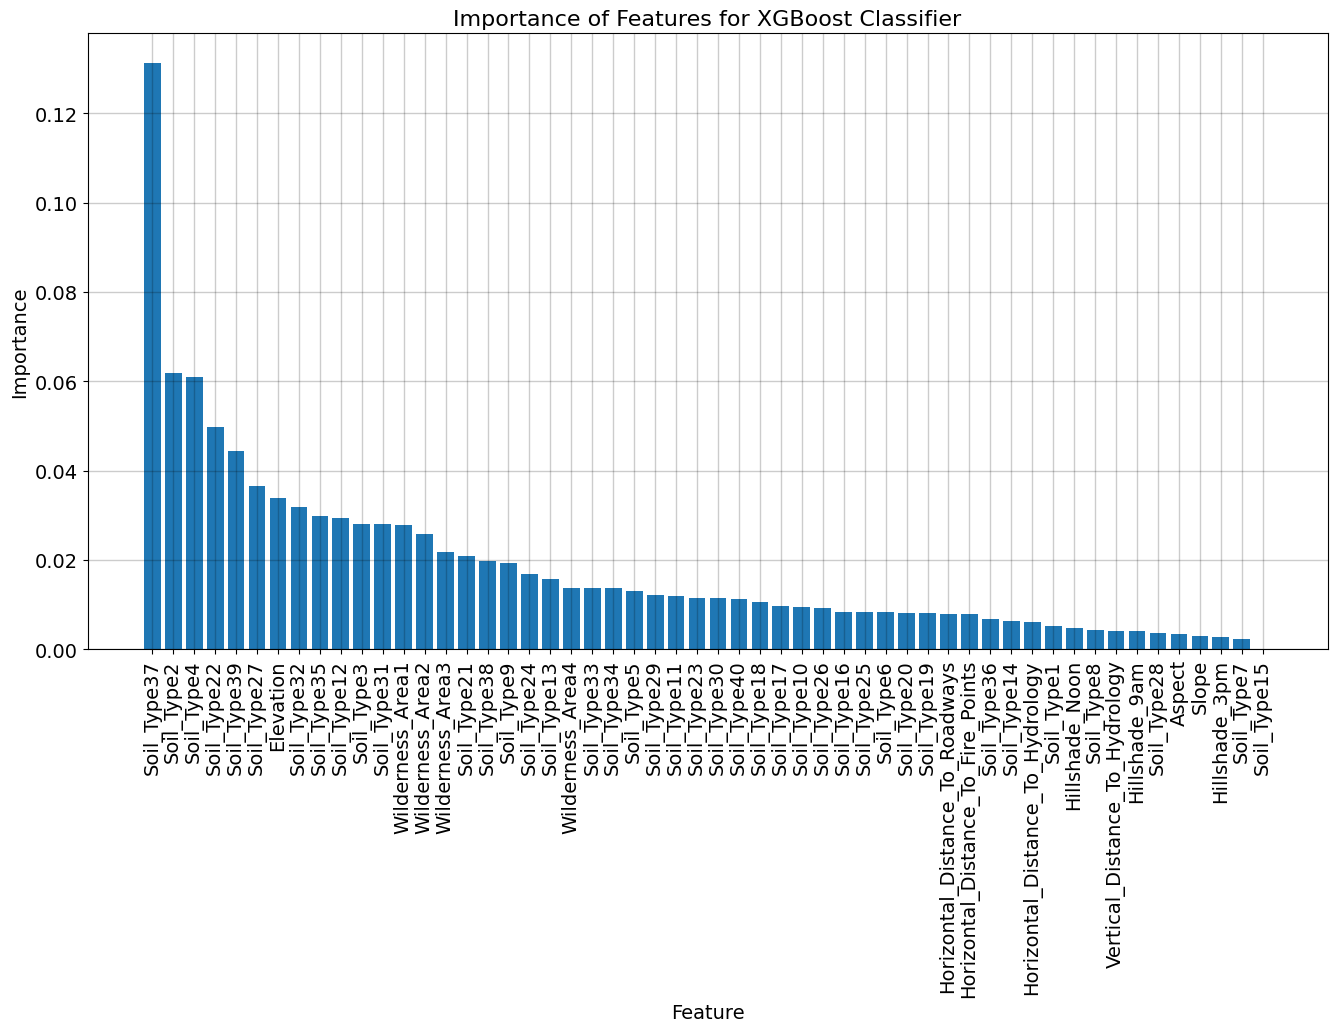

In [14]:
feature_names = data_set.columns.tolist()

# Extracting importance of each feature
feature_importances = best_xgb_clf.feature_importances_

# Indices of the features sorted by importance
indices = np.argsort(feature_importances)[::-1]

plt.figure(figsize=(16, 8))
plt.title('Importance of Features for XGBoost Classifier',color='black', fontsize=16)
plt.bar(range(X_train.shape[1]), feature_importances[indices], align="center")
plt.xticks(range(X_train.shape[1]), np.array(feature_names)[indices], rotation=90)
plt.xlabel('Feature', color='black', fontsize=14)
plt.ylabel('Importance', color='black', fontsize=14)
plt.grid(True, linewidth=1, color='black', alpha=0.2)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.show()

In [15]:
# Computing the performance metrics for the training subset
train_accuracy = accuracy_score(y_train, y_train_pred)
train_precision = precision_score(y_train, y_train_pred, average='weighted')
train_recall = recall_score(y_train, y_train_pred, average='weighted')
train_f1 = f1_score(y_train, y_train_pred, average='weighted')

print("Training Accuracy (in %):",round(train_accuracy*100,3))
print("Training Precision (in %):",round(train_precision*100,3))
print("Training Recall (in %):",round(train_recall*100,3))
print("Training F1 Score (in %):",round(train_f1*100,3))

Training Accuracy (in %): 99.992
Training Precision (in %): 99.992
Training Recall (in %): 99.992
Training F1 Score (in %): 99.992


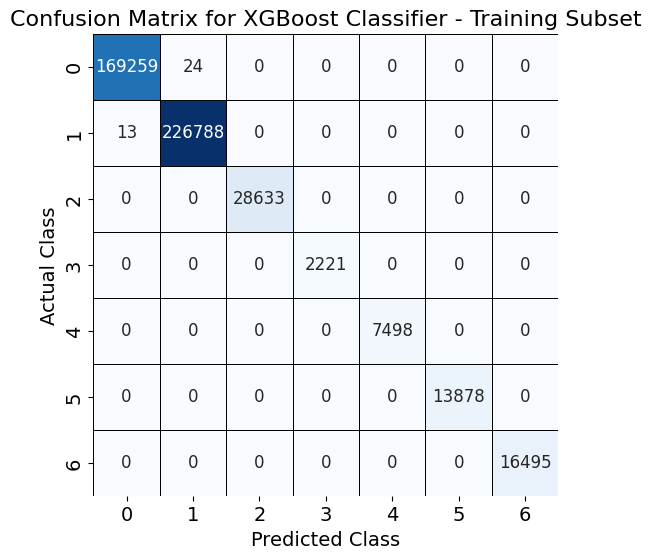

In [16]:
conf_mat_train = confusion_matrix(y_train,y_train_pred)

plt.figure(figsize=(6,6))
sns.heatmap(conf_mat_train, annot=True, fmt='d', cmap='Blues', cbar=False, linewidths=0.5, linecolor='black',
            xticklabels=best_xgb_clf.classes_, yticklabels=best_xgb_clf.classes_, annot_kws={"size": 12})
plt.xlabel('Predicted Class', color='black', fontsize=14)
plt.ylabel('Actual Class', color='black', fontsize=14)
plt.title('Confusion Matrix for XGBoost Classifier - Training Subset', color='black', fontsize=16)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.show()

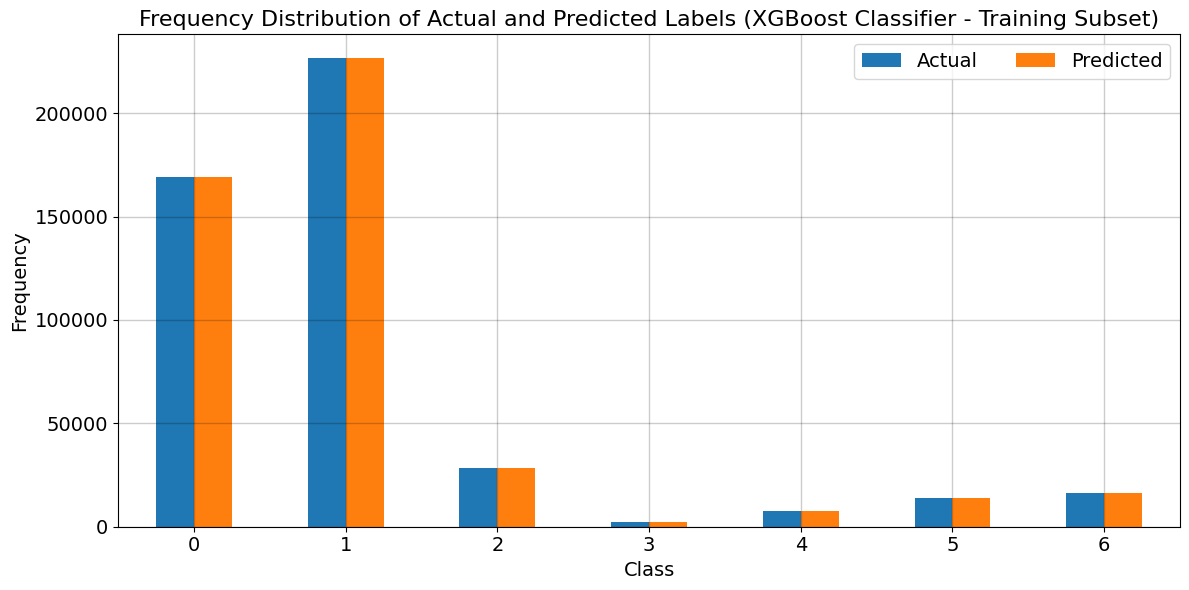

In [17]:
# Plotting the bar graph for frequency distribution of actual and predicted labels (Test Subset)
actual_labels_train, actual_counts_train = np.unique(y_train, return_counts=True)
predicted_labels_train, predicted_counts_train = np.unique(y_train_pred, return_counts=True)

labels_train = np.unique(y_train)

x_train = np.arange(len(labels_train))
width = 0.25

fig, ax = plt.subplots(figsize=(12,6))
rects1_train = ax.bar(x_train - width/2, actual_counts_train, width, label='Actual')
rects2_train = ax.bar(x_train + width/2, predicted_counts_train, width, label='Predicted')

ax.set_xlabel('Class', color='black', fontsize=14)
ax.set_ylabel('Frequency', color='black', fontsize=14)
ax.set_title('Frequency Distribution of Actual and Predicted Labels (XGBoost Classifier - Training Subset)', color='black', fontsize=16)
ax.set_xticks(x_train)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.legend(fontsize=14, ncol=2, loc="upper right")
plt.grid(True, linewidth=1, color='black', alpha=0.2)

ax.set_xlim([-0.5, len(labels_train) - 0.5]) 
fig.tight_layout()
plt.show()

In [18]:
# Computing the performance metrics for the test subset
test_accuracy = accuracy_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred, average='weighted')
test_recall = recall_score(y_test, y_test_pred, average='weighted')
test_f1 = f1_score(y_test, y_test_pred, average='weighted')

print("Test Accuracy (in %):",round(test_accuracy*100,3))
print("Test Precision (in %):",round(test_precision*100,3))
print("Test Recall (in %):",round(test_recall*100,3))
print("Test F1 Score (in %):",round(test_f1*100,3))

Test Accuracy (in %): 96.938
Test Precision (in %): 96.933
Test Recall (in %): 96.938
Test F1 Score (in %): 96.933


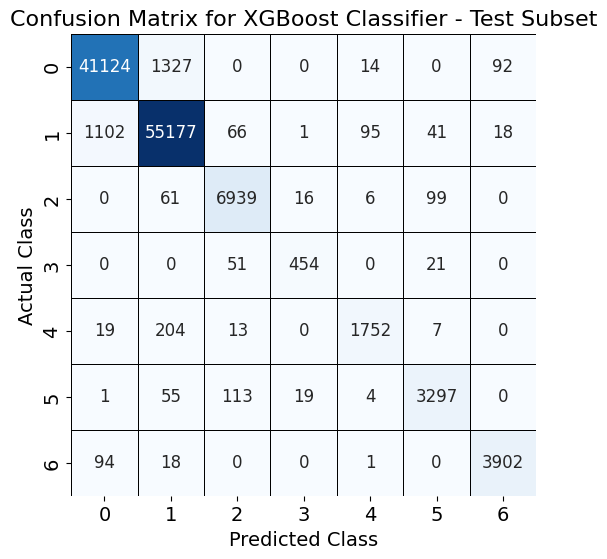

In [19]:
conf_mat_test = confusion_matrix(y_test,y_test_pred)

plt.figure(figsize=(6,6))
sns.heatmap(conf_mat_test, annot=True, fmt='d', cmap='Blues', cbar=False, linewidths=0.5, linecolor='black',
            xticklabels=best_xgb_clf.classes_, yticklabels=best_xgb_clf.classes_, annot_kws={"size": 12})
plt.xlabel('Predicted Class', color='black', fontsize=14)
plt.ylabel('Actual Class', color='black', fontsize=14)
plt.title('Confusion Matrix for XGBoost Classifier - Test Subset', color='black', fontsize=16)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.show()

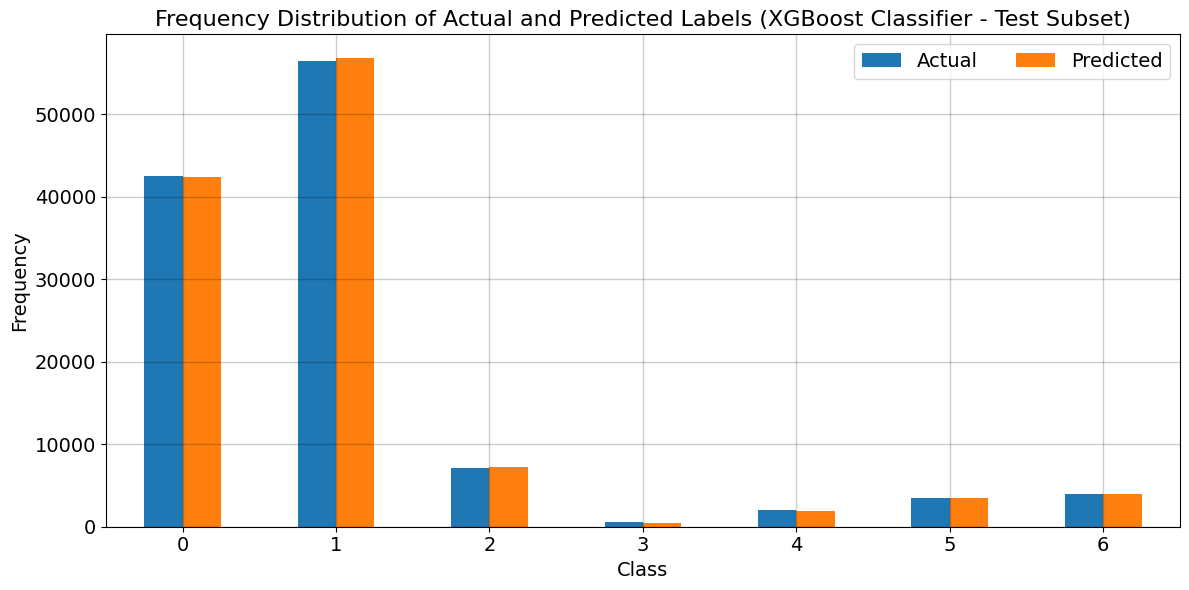

In [20]:
# Plotting the bar graph for frequency distribution of actual and predicted labels (Test Subset)
actual_labels_test, actual_counts_test = np.unique(y_test, return_counts=True)
predicted_labels_test, predicted_counts_test = np.unique(y_test_pred, return_counts=True)

labels_test = np.unique(y_test)

x_test = np.arange(len(labels_test))
width = 0.25

fig, ax = plt.subplots(figsize=(12,6))
rects1_test = ax.bar(x_test - width/2, actual_counts_test, width, label='Actual')
rects2_test = ax.bar(x_test + width/2, predicted_counts_test, width, label='Predicted')

ax.set_xlabel('Class', color='black', fontsize=14)
ax.set_ylabel('Frequency', color='black', fontsize=14)
ax.set_title('Frequency Distribution of Actual and Predicted Labels (XGBoost Classifier - Test Subset)', color='black', fontsize=16)
ax.set_xticks(x_test)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.legend(fontsize=14, ncol=2, loc="upper right")
plt.grid(True, linewidth=1, color='black', alpha=0.2)

ax.set_xlim([-0.5, len(labels_test) - 0.5]) 
fig.tight_layout()
plt.show()

***